In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

%matplotlib inline

# Monte Carlo Methods

## Pesudorandom number generators
### 从标准均匀分布中生成随机数
#### Linear congruential generators(LCG)
$z_{i+1} = (a z_i +c) \mod m$
> Hull-Dobell Theorem: The LCG will have a full period for all seeds if and only if
- c and m are relatively prime,
- c与m互质
- a−1 is divisible by all prime factors of m
- a-1 可以被m的所有质因数整除
- a−1 is a multiple of 4 if mm is a multiple of 4.
- 如果m是4的倍数，a-1也必须是4的倍数

The number $z_0$ is called the seed, and setting it allows us to have a reproducible sequence of “random” numbers. 

In [21]:
def rng(m=2**32,a=1103515245,c=12345):
    rng.current = (a*rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

In [22]:
[rng() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

### Inverst transform method

以指数分布为例

In [34]:
def expon_pdf(x,lmbda=1):
    '''
    指数函数的概率密度函数(pdf)
    '''
    return lmbda*np.exp(-lmbda*x) 

In [36]:
def expon_cdf(x,lmbda=1):
    '''
    指数函数的累积分布函数（CDF）
    '''
    return 1 - np.exp(-lmbda*x)

In [37]:
def expon_icdf(p,lmbda=1):
    '''
    指数函数累积分布函数的反函数 Inverse CDF
    '''
    return -np.log(1-p)/lmbda 

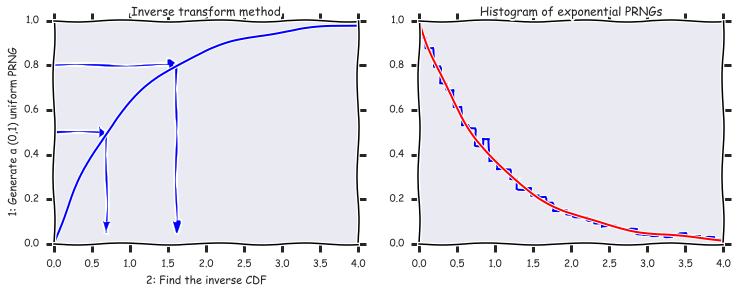

In [53]:
dist = stats.expon()
x = np.linspace(0,4,100)
y = np.linspace(0,1,100)

with plt.xkcd():
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(x,expon_cdf(x))
    plt.axis([0,4,0,1])
    for q in [0.5,0.8]:
        plt.arrow(0,q,expon_icdf(q)-0.1,0,head_width=0.05,head_length=0.1, fc='b', ec='b')
        plt.arrow(expon_icdf(q), q, 0, -q+0.1, head_width=0.1, head_length=0.05, fc='b', ec='b')
    plt.ylabel('1: Generate a (0,1) uniform PRNG')
    plt.xlabel('2: Find the inverse CDF')
    plt.title('Inverse transform method')
    
    plt.subplot(122)
    u = np.random.random(10000)
    v = expon_icdf(u)
    plt.hist(v,histtype='step',bins=100,normed=True,linewidth=2)
    plt.plot(x,expon_pdf(x),linewidth=2)
    plt.axis([0,4,0,1])
    plt.title('Histogram of exponential PRNGs')

### 对任意的分布构造随机数生成器
假设有一个未知分布的样本，我们可以通过插值法估计CDF函数的反函数，
再利用它生成随机数生成器

In [63]:
from scipy.interpolate import interp1d

def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y
    
    def pointwise(x):
        if x < xs[0]:
            return ys[0] + (x-xs[0])*(ys[1]-ys[0]) /(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1] + (x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)
    
    def ufunclike(xs):
        return np.array(list(map(pointwise,np.array(xs))))
    
    return ufunclike

In [64]:
x = np.arange(1,10)
y = np.exp(-x/3.0)
f_i = interp1d(x,y)
f_x = extrap1d(f_i)
f_x([9,10])

array([ 0.04978707,  0.03009069])

(array([ 0.01379314,  0.04689666,  0.04689666,  0.0910347 ,  0.12965548,
         0.19034528,  0.17379351,  0.17655214,  0.1820694 ,  0.14068999,
         0.08827607,  0.06344843,  0.05793117,  0.08275882,  0.05241392,
         0.10206921,  0.16551763,  0.20689704,  0.2124143 ,  0.20413841,
         0.13793136,  0.11034509,  0.03310353,  0.03586215,  0.01379314]),
 array([-2.56227556, -2.19977641, -1.83727727, -1.47477813, -1.11227898,
        -0.74977984, -0.3872807 , -0.02478155,  0.33771759,  0.70021673,
         1.06271588,  1.42521502,  1.78771416,  2.15021331,  2.51271245,
         2.87521159,  3.23771074,  3.60020988,  3.96270902,  4.32520817,
         4.68770731,  5.05020645,  5.41270559,  5.77520474,  6.13770388,
         6.50020302]),
 <a list of 1 Patch objects>)

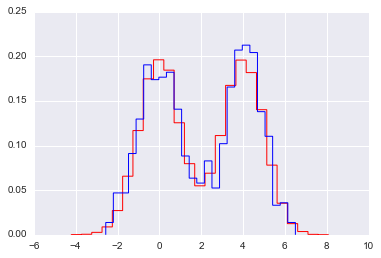

In [67]:
from statsmodels.distributions.empirical_distribution import ECDF
x = np.concatenate([np.random.normal(0,1,10000),
                   np.random.normal(4,1,10000)])
ecdf = ECDF(x)
inv_cdf = extrap1d(interp1d(ecdf.y,ecdf.x,
                           bounds_error=False,
                           assume_sorted=True))
r = np.random.uniform(0,1,1000)
ys = inv_cdf(r)

plt.hist(x,bins=25,histtype='step',color='red',normed=True,linewidth=1)
plt.hist(ys,25,histtype='step',color='blue',normed=True,linewidth=1)

## Rejection sampling
### （truncated）T分布的例子
自由度为10，我们用均匀分布作为proposal distibution

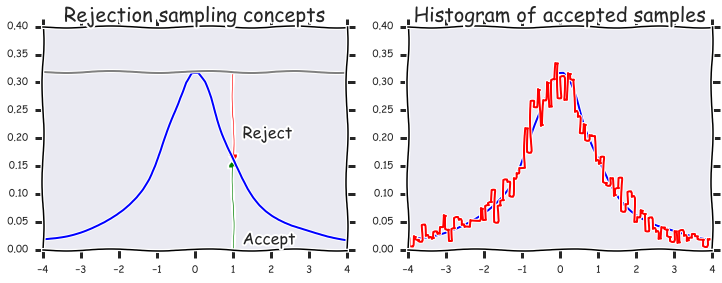

In [98]:
x = np.linspace(-4,4)


df = 10
dist = stats.cauchy()
upper = dist.pdf(0) # 上界，混匀分布，概率密度函数是常数

with plt.xkcd():
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(x,dist.pdf(x)) # 画出概率密度函数
    plt.axhline(upper,color='grey')
    px = 1.0
    plt.arrow(px,0,0,dist.pdf(1.0)-0.01,head_width=0.2,head_length=0.01,fc='g',ec='g')
    plt.arrow(px,upper,0,-(upper-dist.pdf(px)-0.01),head_width=0.2,head_length=0.01,fc='r',ec='r')
    plt.text(px+.25,0.2,'Reject',fontsize=16)
    plt.text(px+0.25,0.01,'Accept',fontsize=16)
    plt.axis([-4,4,0,0.4])
    plt.title('Rejection sampling concepts',fontsize=20)
    
    plt.subplot(122)
    n = 10000
    # generate from sampling distribution
    u = np.random.uniform(-4,4,n)
    r = np.random.uniform(0,upper,n)
    v = u[r < dist.pdf(u)]
    plt.plot(x,dist.pdf(x),linewidth=2)
    
    
    # Plot scaled histogram
    factor = dist.cdf(4) - dist.cdf(-4)
    hist,bin_edges = np.histogram(v,bins=100,normed=True)
    bin_centers=(bin_edges[:-1]+bin_edges[1:]) / 2
    plt.step(bin_centers,factor*hist,linewidth=2)
    
    plt.axis([-4,4,0,0.4])
    plt.title('Histogram of accepted samples', fontsize=20)

## Importance sampling:

计算积分：$\int_0^{\pi}\sin(x)x dx$

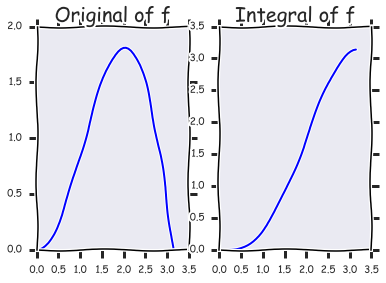

In [2]:
## 正态分布的参数
mu = 2
sig = 0.7

f = lambda x : x*np.sin(x)
#函数f的不定积分
anti_derivative_f = lambda x : np.sin(x) - x*np.cos(x)

xs = np.linspace(0,np.pi)

with plt.xkcd():
    plt.subplot(121)
    plt.plot(xs,f(xs))
    plt.title('Original of f',fontsize=20)
    
    plt.subplot(122)
    plt.plot(xs,anti_derivative_f(xs))
    plt.title('Integral of f',fontsize=20)

Exact solution is: 3.141592653589793

Mean basic MC estimate:  3.14275700658
Standard deviation of our estimates:  0.0617405967604


Mean importance sampling MC estimate:  3.14127548204
Standard deviation of our estimate:  0.0165832597502




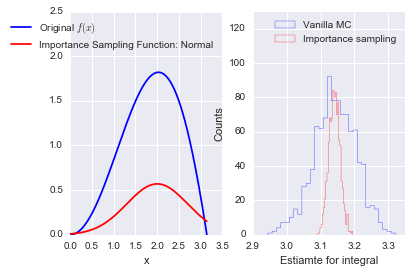

In [36]:
#从函数的图像上可以看出，整个分类的形态近似于正态分布，
#因此我们选择正态分布作为proposal function

dist = stats.norm(mu,sig)
q = dist.pdf
normfun = dist.cdf

weight = lambda x : f(x) / q(x)

# Number of draws
N = 1000
xmin = 0
xmax = np.pi
xs = np.linspace(xmin,xmax,N)


plt.subplot(121)
plt.plot(xs,f(xs),'b',label=u"Original $f(x)$")
plt.plot(xs,q(xs),'r',label=u"Importance Sampling Function: Normal")
plt.xlabel('x')
plt.ylim(0,2.5)
plt.legend()

# 精确的答案，求积分
Iexact = anti_derivative_f(np.pi) - anti_derivative_f(0)
print("Exact solution is: {}\n".format(Iexact))
print

# 蒙特卡洛趋近
Ivmc = np.zeros(1000)
#做1000次蒙特卡罗趋近
for k in np.arange(1000):
    # 从均匀分布中随机抽样N个点
    x = np.random.uniform(low=xmin,high=xmax,size=N)
    # 单次的定积分趋近
    Ivmc[k] = (xmax-xmin)*np.mean(f(x))

print("Mean basic MC estimate: ",np.mean(Ivmc))
print("Standard deviation of our estimates: ",np.std(Ivmc))
print("\n")

# importance sampling
Iis = np.zeros(1000)
for k in np.arange(0,1000):
    # draw from a normal distribution
    xis = dist.rvs(N)
    xis = xis[(xis < xmax) & (xis>xmin)]
    
    # normalization for Gaussian from 0..pi
    # 此时分布是没有归一化的
    normal = normfun(np.pi) - normfun(0)
    
    Iis[k] = np.mean(f(xis)/q(xis)) * normal

print("Mean importance sampling MC estimate: ",np.mean(Iis))
print("Standard deviation of our estimate: ",np.std(Iis))
print("\n")


plt.subplot(122)
plt.hist(Ivmc,30,color='b',histtype='step',label='Vanilla MC')
plt.hist(Iis,30,color='r',histtype='step',label='Importance sampling')
plt.ylim(0,130)
plt.xlabel('Estiamte for integral')
plt.ylabel("Counts")
plt.legend()
plt.show()

从数据上看出，相比普通的蒙特卡洛估计，重要性抽样降低了积分的方差